In [1]:
import os
import io
import cv2
import random
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from gtts import gTTS
from IPython.display import Audio, display
from googletrans import Translator
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import CLIPModel, CLIPProcessor
from torch.utils.data import Dataset, DataLoader

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

d:\2nd rev\viki_2nd\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [2]:
# ================= LOAD CLIP =================
print("Loading CLIP model...")
model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name).to(device)
clip_processor = CLIPProcessor.from_pretrained(model_name)

# ================= DATASET DOWNLOAD =================
print("Downloading dataset...")
data_dir = kagglehub.dataset_download("smaranjitghose/corn-or-maize-leaf-disease-dataset")
actual_data_path = os.path.join(data_dir, "data") if os.path.exists(os.path.join(data_dir, "data")) else data_dir

class_names = ['Blight', 'Common Rust', 'Gray Leaf Spot', 'Healthy']
class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

# ================= IMAGE COLLECTION =================
all_images = []
all_labels = []

for root, dirs, files in os.walk(actual_data_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            for cls in class_names:
                if cls.replace(" ", "_").lower() in root.lower():
                    all_images.append(os.path.join(root, file))
                    all_labels.append(class_to_idx[cls])
                    break

print(f"Total images found: {len(all_images)}")

Loading CLIP model...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Total images found: 4188


In [3]:
# ================= PREPROCESSING =================
def apply_advanced_preprocessing(image):
    """
    Applies CLAHE for contrast, Gaussian Blur for noise reduction, and resizes for CLIP.
    """
    img_cv = np.array(image)
    if len(img_cv.shape) == 2:
        img_cv = cv2.cvtColor(img_cv, cv2.COLOR_GRAY2RGB)

    # Convert to LAB for CLAHE on Lightness channel
    lab = cv2.cvtColor(img_cv, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    
    # Denoise
    final_img = cv2.GaussianBlur(final_img, (3, 3), 0)

    # CRITICAL FIX: Resize here to ensure consistency for CLIP
    final_img = cv2.resize(final_img, (224, 224))
    
    return Image.fromarray(final_img)

# ================= DATASET & DATALOADERS =================
class CornDiseaseDataset(Dataset):
    def __init__(self, image_paths, labels, processor):
        self.image_paths = image_paths
        self.labels = labels
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        original_image = Image.open(img_path).convert("RGB")
        preprocessed_image = apply_advanced_preprocessing(original_image)

        pixel_values = self.processor(
            images=preprocessed_image, 
            return_tensors="pt"
        )["pixel_values"].squeeze(0)

        return pixel_values, torch.tensor(label, dtype=torch.long)

print("Splitting dataset...")
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

train_dataset = CornDiseaseDataset(train_paths, train_labels, clip_processor)
val_dataset = CornDiseaseDataset(val_paths, val_labels, clip_processor)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders successfully created!")# ================= PREPROCESSING =================
def apply_advanced_preprocessing(image):
    """
    Applies CLAHE for contrast, Gaussian Blur for noise reduction, and resizes for CLIP.
    """
    img_cv = np.array(image)
    if len(img_cv.shape) == 2:
        img_cv = cv2.cvtColor(img_cv, cv2.COLOR_GRAY2RGB)

    # Convert to LAB for CLAHE on Lightness channel
    lab = cv2.cvtColor(img_cv, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    
    # Denoise
    final_img = cv2.GaussianBlur(final_img, (3, 3), 0)

    # CRITICAL FIX: Resize here to ensure consistency for CLIP
    final_img = cv2.resize(final_img, (224, 224))
    
    return Image.fromarray(final_img)

# ================= DATASET & DATALOADERS =================
class CornDiseaseDataset(Dataset):
    def __init__(self, image_paths, labels, processor):
        self.image_paths = image_paths
        self.labels = labels
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        original_image = Image.open(img_path).convert("RGB")
        preprocessed_image = apply_advanced_preprocessing(original_image)

        pixel_values = self.processor(
            images=preprocessed_image, 
            return_tensors="pt"
        )["pixel_values"].squeeze(0)

        return pixel_values, torch.tensor(label, dtype=torch.long)

print("Splitting dataset...")
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

train_dataset = CornDiseaseDataset(train_paths, train_labels, clip_processor)
val_dataset = CornDiseaseDataset(val_paths, val_labels, clip_processor)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders successfully created!")

Splitting dataset...
DataLoaders successfully created!
Splitting dataset...
DataLoaders successfully created!


In [4]:
# ================= MODEL DEFINITION =================
class CLIPFineTuneClassifier(nn.Module):
    def __init__(self, vision_model, num_classes):
        super().__init__()
        self.vision_model = vision_model
        
        # Freeze parameters of the vision model
        for param in self.vision_model.parameters():
            param.requires_grad = False
            
        # Add a new linear classification layer
        self.classifier = nn.Linear(vision_model.config.hidden_size, num_classes)

    def forward(self, pixel_values):
        vision_outputs = self.vision_model(pixel_values=pixel_values)
        pooled_output = vision_outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits

# ================= TRAINING LOOP =================
model = CLIPFineTuneClassifier(clip_model.vision_model, len(class_to_idx)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-3)

print("Model, criterion, and optimizer initialized.")

num_epochs = 5
best_val_accuracy = 0.0

print("Starting fine-tuning...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], Loss: {running_loss / (i+1):.4f}")

    print(f"Epoch [{epoch+1}/{num_epochs}] finished. Training Loss: {running_loss / len(train_dataloader):.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    current_val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss / len(val_dataloader):.4f}, Validation Accuracy: {current_val_accuracy:.2f}%")

    if current_val_accuracy > best_val_accuracy:
        best_val_accuracy = current_val_accuracy
        torch.save(model.state_dict(), 'best_clip_finetuned_classifier.pth')
        print(f"New best model saved with accuracy: {best_val_accuracy:.2f}%")

print("Fine-tuning complete!")

Model, criterion, and optimizer initialized.
Starting fine-tuning...
Epoch [1/5], Step [10/105], Loss: 1.0386
Epoch [1/5], Step [20/105], Loss: 0.8276
Epoch [1/5], Step [30/105], Loss: 0.6995
Epoch [1/5], Step [40/105], Loss: 0.6197
Epoch [1/5], Step [50/105], Loss: 0.5676
Epoch [1/5], Step [60/105], Loss: 0.5306
Epoch [1/5], Step [70/105], Loss: 0.5024
Epoch [1/5], Step [80/105], Loss: 0.4813
Epoch [1/5], Step [90/105], Loss: 0.4591
Epoch [1/5], Step [100/105], Loss: 0.4425
Epoch [1/5] finished. Training Loss: 0.4344
Validation Loss: 0.2653, Validation Accuracy: 90.57%
New best model saved with accuracy: 90.57%
Epoch [2/5], Step [10/105], Loss: 0.2738
Epoch [2/5], Step [20/105], Loss: 0.2612
Epoch [2/5], Step [30/105], Loss: 0.2625
Epoch [2/5], Step [40/105], Loss: 0.2559
Epoch [2/5], Step [50/105], Loss: 0.2582
Epoch [2/5], Step [60/105], Loss: 0.2543
Epoch [2/5], Step [70/105], Loss: 0.2450
Epoch [2/5], Step [80/105], Loss: 0.2422
Epoch [2/5], Step [90/105], Loss: 0.2357
Epoch [2/5]

Loading the best fine-tuned model...

Overall Accuracy: 0.9379474940334129
Classification Report:
                 precision    recall  f1-score   support

        Blight       0.86      0.95      0.90       229
   Common Rust       1.00      0.96      0.98       261
Gray Leaf Spot       0.86      0.74      0.79       115
       Healthy       1.00      1.00      1.00       233

      accuracy                           0.94       838
     macro avg       0.93      0.91      0.92       838
  weighted avg       0.94      0.94      0.94       838



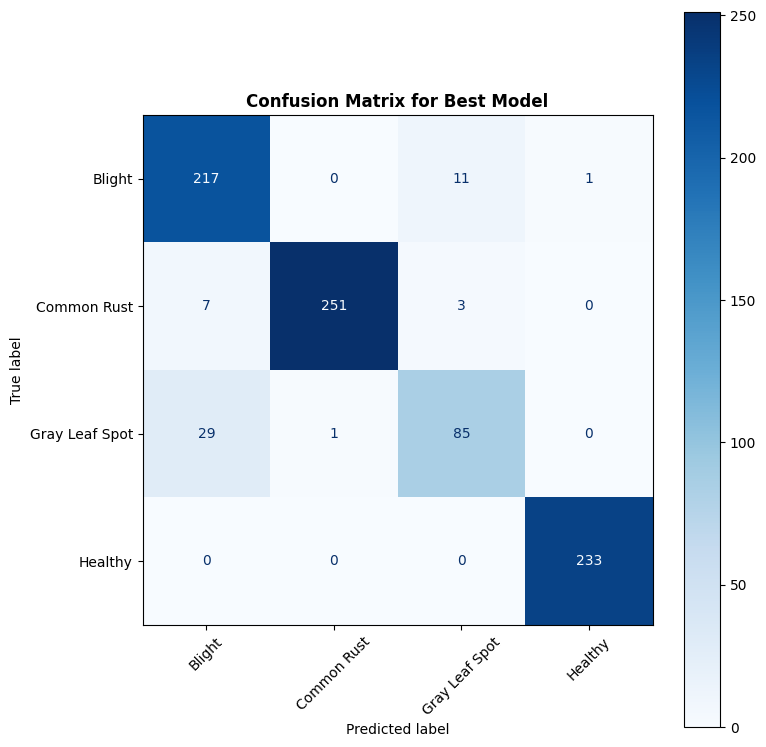

Fine-tuned model evaluation complete.


In [5]:
# ================= EVALUATION =================
def evaluate_finetuned_model(model, dataloader, idx_to_class):
    model.eval()
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend([idx_to_class[p.item()] for p in predicted])
            all_true_labels.extend([idx_to_class[l.item()] for l in labels])

    accuracy = accuracy_score(all_true_labels, all_predictions)
    report = classification_report(all_true_labels, all_predictions, zero_division=0)

    print(f"\nOverall Accuracy: {accuracy:.16f}")
    print("Classification Report:\n", report)

    # Plot Confusion Matrix
    cm = confusion_matrix(all_true_labels, all_predictions, labels=list(idx_to_class.values()))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(idx_to_class.values()))
    
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)
    plt.title("Confusion Matrix for Best Model", fontweight='bold')
    plt.tight_layout()
    plt.show()

print("Loading the best fine-tuned model...")
model.load_state_dict(torch.load('best_clip_finetuned_classifier.pth'))

evaluate_finetuned_model(model, val_dataloader, idx_to_class)
print("Fine-tuned model evaluation complete.")

In [6]:
# ================= TEST & AUDIO SETUP =================
recommendations = {
    "Blight": "Apply fungicides containing Mancozeb.",
    "Common Rust": "Apply fungicides containing Pyraclostrobin.",
    "Gray Leaf Spot": "Apply fungicides containing Azoxystrobin.",
    "Healthy": "No treatment needed. Keep it up!"
}

symptom_map = {
    "Blight": "long cigar-shaped lesions",
    "Common Rust": "reddish raised spots",
    "Gray Leaf Spot": "rectangular gray spots",
    "Healthy": "clear vibrant texture"
}

def run_test():
    model.load_state_dict(torch.load("best_clip_finetuned_classifier.pth"))
    model.eval()

    img_path = random.choice(all_images)

    # 1. Original image
    original_image = Image.open(img_path).convert("RGB")
    original_np = np.array(original_image)

    # 2. Preprocessed image
    preprocessed_image = apply_advanced_preprocessing(original_image)
    preprocessed_np = np.array(preprocessed_image)

    # CLIP inference
    pixel_values = clip_processor(
        images=preprocessed_image,
        return_tensors="pt"
    )["pixel_values"].to(device)

    with torch.no_grad():
        outputs = model(pixel_values)
        probs = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probs, 1)

    predicted_class = idx_to_class[predicted.item()]
    conf_score = confidence.item() * 100
    symptom_text = symptom_map[predicted_class]
    recommendation_text = recommendations[predicted_class]

    # ✅ Final Text Formatting
    if predicted_class == "Healthy":
        final_text = (
            f"CNN+CLIP Result: Predicted {conf_score:.1f}% as {predicted_class}.\n"
            f"Reasoning: The leaf is not affected. Recommendation: {recommendation_text}"
        )
    else:
        final_text = (
            f"CNN+CLIP Result: Predicted {conf_score:.1f}% as {predicted_class}.\n"
            f"Reasoning: It is affected since it shows {symptom_text}. Recommendation: {recommendation_text}"
        )

    print("\n" + "="*50)
    print(final_text)
    print("="*50)

    # ================= 2-PANEL OUTPUT PLOT =================
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    # Panel 1: Original
    axes[0].imshow(original_np)
    axes[0].set_title("1. Original Input Image", fontsize=12, fontweight='bold')
    axes[0].axis("off")

    # Panel 2: Pre-processed
    axes[1].imshow(preprocessed_np)
    axes[1].set_title("2. Pre-processed (CLAHE + Gaussian Blur)", fontsize=12, fontweight='bold')
    axes[1].axis("off")   

    # Add the light blue result box at the bottom
    plt.figtext(
        0.5, 0.08, 
        final_text, 
        ha="center", 
        fontsize=13, 
        fontweight='bold', 
        bbox={"facecolor": "lightblue", "alpha": 0.5, "pad": 10, "edgecolor": "steelblue"}
    )

    plt.tight_layout(rect=[0, 0.18, 1, 0.95])
    plt.show()

    # ================= AUDIO OUTPUTS =================
    # English Audio
    print("Generating English Audio...")
    tts_en = gTTS(text=final_text, lang='en')
    fp_en = io.BytesIO()
    tts_en.write_to_fp(fp_en)
    fp_en.seek(0)
    display(Audio(fp_en.read(), autoplay=True))

    # Tamil Audio
    print("Generating Tamil Audio...")
    try:
        translator = Translator()
        tamil_text = translator.translate(final_text, dest='ta').text
        tts_ta = gTTS(text=tamil_text, lang='ta')
        fp_ta = io.BytesIO()
        tts_ta.write_to_fp(fp_ta)
        fp_ta.seek(0)
        display(Audio(fp_ta.read()))
    except Exception as e:
        print(f"Tamil translation skipped. Error: {e}")



CNN+CLIP Result: Predicted 99.7% as Blight.
Reasoning: It is affected since it shows long cigar-shaped lesions. Recommendation: Apply fungicides containing Mancozeb.


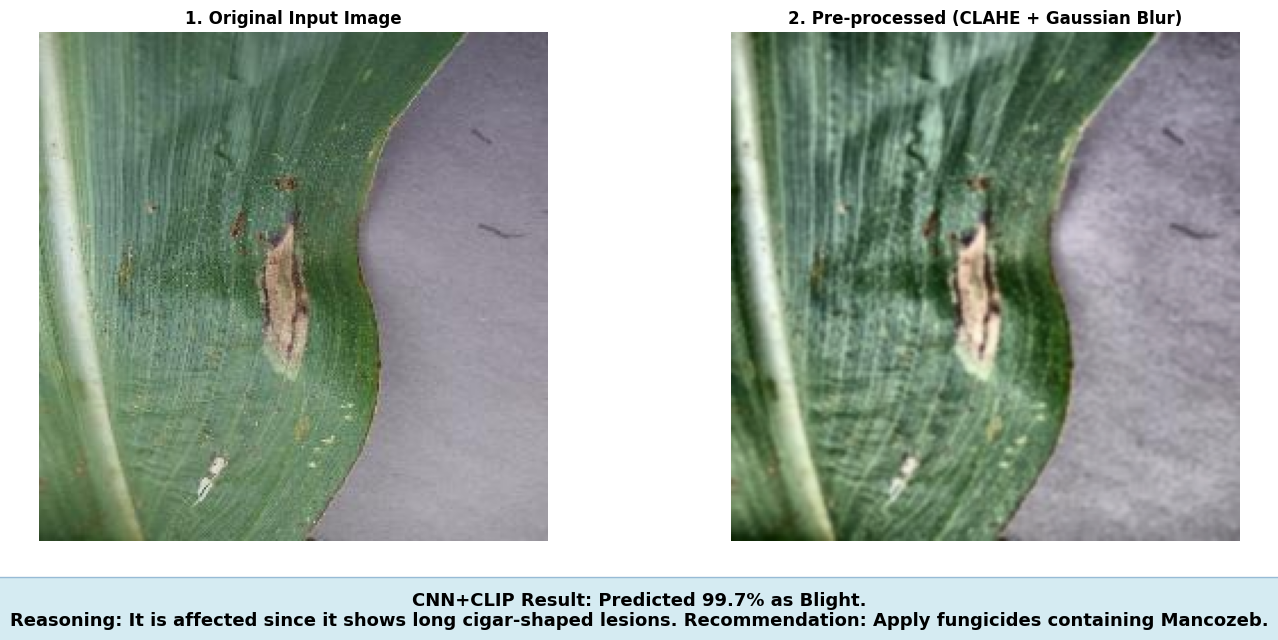

Generating English Audio...


Generating Tamil Audio...


In [7]:
# Run the test
run_test()


CNN+CLIP Result: Predicted 93.3% as Gray Leaf Spot.
Reasoning: It is affected since it shows rectangular gray spots. Recommendation: Apply fungicides containing Azoxystrobin.


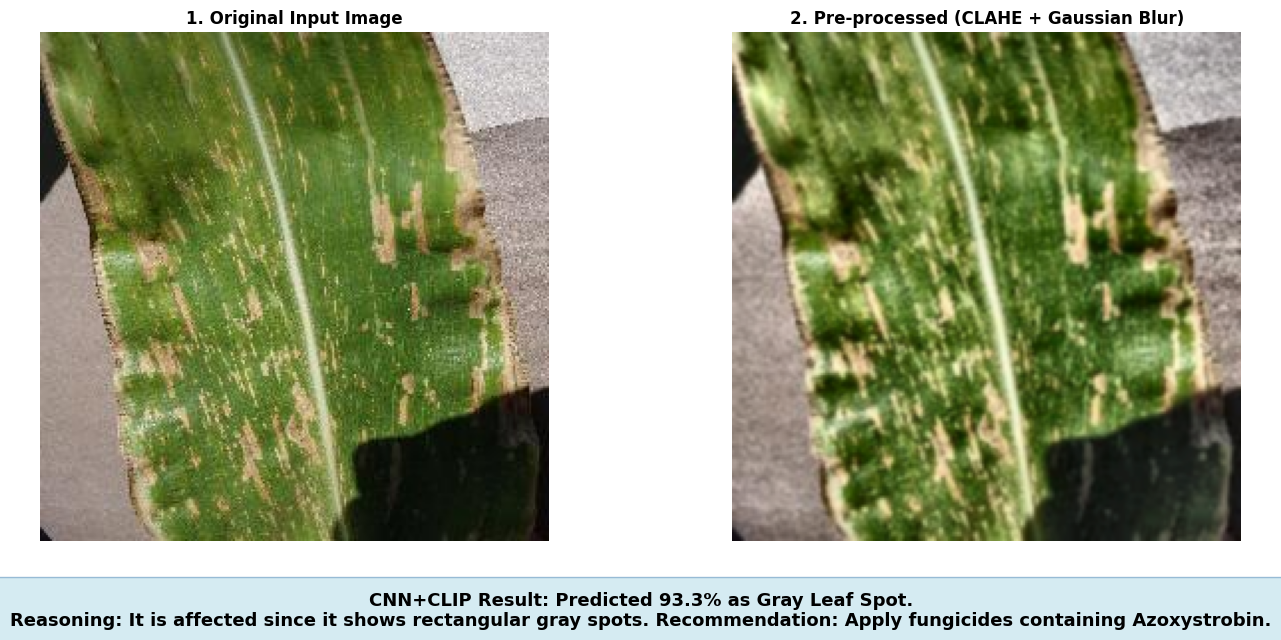

Generating English Audio...


Generating Tamil Audio...


In [8]:
# Run the test
run_test()


CNN+CLIP Result: Predicted 99.8% as Common Rust.
Reasoning: It is affected since it shows reddish raised spots. Recommendation: Apply fungicides containing Pyraclostrobin.


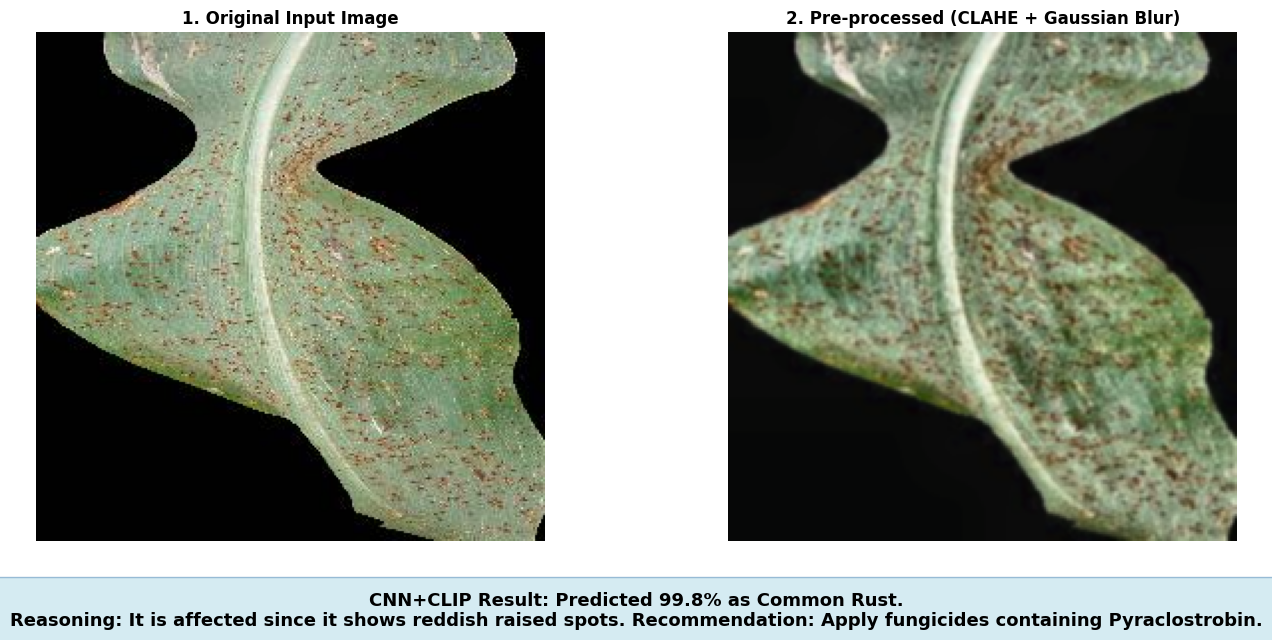

Generating English Audio...


Generating Tamil Audio...


In [12]:
# Run the test
run_test()


CNN+CLIP Result: Predicted 100.0% as Healthy.
Reasoning: The leaf is not affected. Recommendation: No treatment needed. Keep it up!


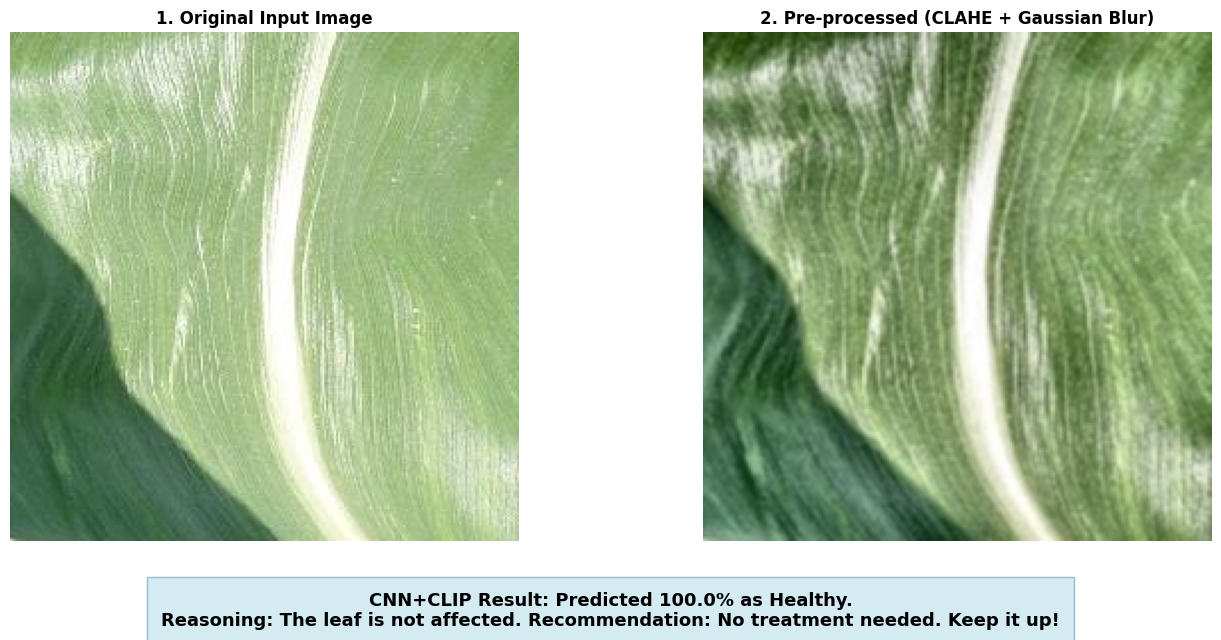

Generating English Audio...


Generating Tamil Audio...


In [16]:
# Run the test
run_test()